In [ ]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

### Imports

In [2]:
from collections import deque
import random

import pandas as pd
import numpy as np
import itertools
import logging, os

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.uint32)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
users_df = pd.DataFrame(users_list, columns=['UserID','Gender','Age','Occupation','Zip-code'])

In [4]:
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [5]:
movies_df.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children's",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western']

In [8]:
movies_genres_df = movies_df[['MovieID', 'Genres']]
movies_genres_df.head(5)

,MovieID,Genres
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama
4,5,Comedy


In [9]:
def _split_and_index(string):
    string = string.split('|')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string

In [10]:
movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))
movies_genres_df.head(5)

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [11]:
user_movie_rating_df = ratings_df[['UserID','MovieID','Rating']]
user_movie_rating_df.head(5)

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [12]:
class MovieGenreEmbedding(tf.keras.Model):
    def __init__(self, len_movies, len_genres, embedding_size):
        super(MovieGenreEmbedding, self).__init__()
        self.m_g_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
        # dot product
        self.m_g_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
        # output
        self.m_g_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_g_input(x)
        memb = self.m_embedding(x[0])
        gemb = self.g_embedding(x[1])
        m_g = self.m_g_merge([memb, gemb])
#         m_g = self.reshape(m_g)
        return self.m_g_fc(m_g)

In [13]:
class UserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        m_u = self.m_u_merge([x[1], uemb])
        return self.m_u_fc(m_u)

In [14]:
## Data generator
# Movie Genre batch generator
# movie genre data generator
movies_genres_df.head()

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [15]:
movies_genres_dict = {m : g for m, g in zip(movies_genres_df["MovieID"],movies_genres_df["Genres"])}
movies_genres_dict[1]

[2, 3, 4]

In [16]:
positive_m_g_pairs = []
negative_m_g_pairs = []
for movie in movies_genres_df["MovieID"]:
    for i in range(len(genres)):
        if i in movies_genres_dict[movie]:
            positive_m_g_pairs.append((movie, i, 1))
        else:
            negative_m_g_pairs.append((movie, i, 0))

In [17]:
def generate_movie_genre_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
    
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)
    
    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data
        
        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [18]:
# user movie data generator
user_movie_rating_df = user_movie_rating_df.apply(np.int32)
user_movie_rating_df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [19]:
# User batch generator
modified_user_movie_rating_df = user_movie_rating_df.apply(np.int32)
index_names = modified_user_movie_rating_df[modified_user_movie_rating_df['Rating']<4].index
modified_user_movie_rating_df = modified_user_movie_rating_df.drop(index_names)
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Rating', axis=1)
u_m_pairs = modified_user_movie_rating_df.to_numpy()
u_m_pairs[:5]

array([[   1, 1193],
       [   1, 3408],
       [   1, 2355],
       [   1, 1287],
       [   1, 2804]], dtype=int32)

In [20]:
positive_user_movie_dict = {u : [] for u in range(1, max(modified_user_movie_rating_df['UserID'])+1)}

for data in modified_user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
positive_user_movie_dict[1]

[1193,
 3408,
 2355,
 1287,
 2804,
 594,
 919,
 595,
 938,
 2398,
 2918,
 1035,
 2791,
 2018,
 3105,
 2797,
 1270,
 527,
 48,
 1097,
 1721,
 1545,
 2294,
 3186,
 1566,
 588,
 1907,
 783,
 1836,
 1022,
 2762,
 150,
 1,
 1961,
 1962,
 2692,
 260,
 1028,
 1029,
 1207,
 2028,
 531,
 3114,
 608,
 1246]

In [21]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_movie_rating_df['UserID'])+1
    max_movie_id = max(modified_user_movie_rating_df['MovieID'])+1
    
    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)
        
        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [22]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

MAX_EPOCH = 100
MOVIE_BATCH_SIZE = 128
MOVIE_STEP_PER_EPOCH = len(positive_m_g_pairs)//MOVIE_BATCH_SIZE

In [23]:
# Movie Genre Embedding
m_g_model = MovieGenreEmbedding(LEN_MOVIES, LEN_GENRES, EMBEDDING_SIZE)
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "movie_genre_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
movie_embedding (Embedding)  multiple                  395300    
_________________________________________________________________
genre_embedding (Embedding)  multiple                  1900      
_________________________________________________________________
movie_genre_dot (Dot)        multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2         
Total params: 397,202
Trainable params: 397,202
Non-trainable params: 0
_________________________________________________________________


In [24]:
# optimizer
optimizer = tf.keras.optimizers.Adam()

# loss
bce = tf.keras.losses.BinaryCrossentropy()
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_g_train_step(m_g_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_g_model(m_g_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_g_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

    m_g_train_loss(loss)
    m_g_train_accuracy(labels, predictions)

# for log
m_g_losses = []

for epoch in range(MAX_EPOCH):
    
    m_g_generator = generate_movie_genre_batch(positive_m_g_pairs, negative_m_g_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(MOVIE_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, g_batch, m_g_label_batch = next(m_g_generator)
        m_g_train_step([m_batch, g_batch], m_g_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}', end='\r')

    m_g_losses.append(m_g_train_loss.result())

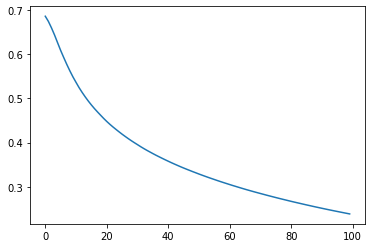

In [25]:
plt.plot(m_g_losses)

In [27]:
!mkdir -p save_weights

In [28]:
m_g_model.save_weights('./save_weights/m_g_model_weights.h5')

In [29]:
# User Movie Embedding
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

u_m_model = UserMovieEmbedding(LEN_USERS, EMBEDDING_SIZE)
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

Model: "user_movie_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
user_embedding (Embedding)   multiple                  604100    
_________________________________________________________________
movie_user_dot (Dot)         multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2         
Total params: 604,102
Trainable params: 604,102
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()

# loss
bce = tf.keras.losses.BinaryCrossentropy()
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)
    
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('movie_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}', end='\r')

    u_m_losses.append(u_m_train_loss.result())

In [ ]:
plt.plot(u_m_losses)

In [ ]:
u_m_model.save_weights('./save_weights/u_m_model_weights.h5')

In [ ]:
# embedded movie dataframe
embedded_movie = movies_genres_df['MovieID'].apply(m_g_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)

for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
    
embedded_movie_df.head()

In [ ]:
# PCA
movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]

movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

In [ ]:
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

In [ ]:
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
embedded_user = users_df['UserID'].apply(np.int32).apply(u_m_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

In [ ]:
users_df.head()

In [ ]:
user_scaled = StandardScaler().fit_transform(embedded_user_df)
pca = PCA(n_components=2)
pca.fit(user_scaled)
user_pca = pca.transform(user_scaled)
pca_columns=[f'{n}' for n in range(2)]

user_df_pca = pd.DataFrame(user_pca,columns=pca_columns)
user_df_pca = pd.concat([user_df_pca, users_df["Gender"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Age"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Zip-code"]], axis=1)
user_df_pca.head()

In [ ]:
fig = px.scatter(user_df_pca, x='0', y='1', hover_data=user_df_pca)
fig.show()

In [ ]:
tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

In [ ]:
fig = px.scatter(tsne_df, x='x', y='y', hover_data=tsne_df)
fig.show()

In [ ]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

In [ ]:
class TestUserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, len_movies, embedding_size):
        super(TestUserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        memb = self.m_embedding(x[1])
        m_u = self.m_u_merge([memb, uemb])
        return self.m_u_fc(m_u)

In [ ]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024
test_model = TestUserMovieEmbedding(LEN_USERS, LEN_MOVIES, EMBEDDING_SIZE)

In [ ]:
test_model([np.zeros((1)),np.zeros((1))])
test_model.summary()

In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()

# loss
bce = tf.keras.losses.BinaryCrossentropy()
test_train_loss = tf.keras.metrics.Mean(name='train_loss')
test_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

In [ ]:
@tf.function
def test_train_step(test_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = test_model(test_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, test_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, test_model.trainable_variables))

    test_train_loss(loss)
    test_train_accuracy(labels, predictions)

In [ ]:
# for log
test_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    test_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(test_generator)
        test_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {test_train_loss.result():0.4f}, Accuracy: {test_train_accuracy.result() * 100:0.1f}', end='\r')

    test_losses.append(test_train_loss.result())

In [ ]:
embedded_movie = movies_genres_df['MovieID'].apply(test_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

In [ ]:
movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

In [ ]:
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

In [ ]:
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
embedded_user = users_df['UserID'].apply(np.int32).apply(test_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

In [ ]:
tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

In [ ]:
fig = px.scatter(tsne_df, x='x', y='y', color='Age', hover_data=tsne_df)
fig.show()

In [ ]:
test_model.save_weights('./save_weights/user_movie_at_once.h5')